In [71]:
import os
import pickle
from datetime import datetime

import numpy as np
from tqdm import tqdm

# --------------------------------------------------------
# 1) CONFIG
# --------------------------------------------------------
BASE_DIR = r"C:\Users\mh272\Box\NED3_Share\Ishraq Hossain\CWRU\test17_17th Oct_Friday\4\Wave Form Streaming"

CHANNEL_FOLDERS = [
    "Channel 1",
    "Channel 2",
]

# how many header lines to skip when reading numeric data
HEADER_LINES = 12

In [72]:
# --------------------------------------------------------
# 2) Helper: read header from first csv and extract metadata
# --------------------------------------------------------
def read_channel_metadata(first_csv_path):
    """
    Reads the first HEADER_LINES lines from the CSV and tries to pull:
      - sample interval (seconds)
      - stream start time (HH:MM:SS)
    Adjust the parsing lines if your header looks a bit different.
    """
    with open(first_csv_path, "r") as f:
        header_lines = [next(f) for _ in range(HEADER_LINES)]

    # ---- sample interval ----
    # assuming line 4 (index 3) looks like: "Sample Interval: 1.000000E-06"
    sample_interval_line = header_lines[3]
    sample_interval = float(sample_interval_line.split(":")[-1].strip())

    # ---- stream start time ----
    # assuming line 3 (index 2) ends with something like '12:34:56'
    stream_start_line = header_lines[2]
    stream_start_str = stream_start_line.split()[-1].strip()
    stream_start_time = datetime.strptime(stream_start_str, "%H:%M:%S")

    return {
        "sample_interval": sample_interval,
        "stream_start_time": stream_start_time,
        "raw_header": header_lines,  # keep if you want to inspect later
    }



In [73]:
# --------------------------------------------------------
# 3) Helper: discover and sort csvs for a channel
# --------------------------------------------------------
def list_sorted_csvs(channel_path):
    """
    Returns a list of CSV filenames in the channel folder,
    sorted by the start-sample part in the filename.

    New filenames look like:
        5gs_22C_1_0_1048499.csv
        5gs_22C_1_1048500_2096999.csv

    where:
        parts[-3] = channel (1 or 2)
        parts[-2] = start sample
        parts[-1] = end sample
    """
    all_files = [f for f in os.listdir(channel_path) if f.lower().endswith(".csv")]
    if not all_files:
        return []

    def sort_key(fn):
        base = os.path.splitext(fn)[0]
        parts = base.split("_")
        try:
            # second-to-last is the start index, e.g. "0" or "1048500"
            start_sample = int(parts[-2])
        except (IndexError, ValueError):
            start_sample = 0
        return start_sample

    return sorted(all_files, key=sort_key)


In [74]:
# --------------------------------------------------------
# 4) Main routine to process ONE channel
# --------------------------------------------------------
def process_channel(base_dir, channel_name):
    channel_path = os.path.join(base_dir, channel_name)
    if not os.path.isdir(channel_path):
        print(f"❌ Channel folder not found: {channel_path}")
        return None, None

    print(f"\n=== Processing {channel_name} ===")

    # where to save pickle (in base dir, as you asked)
    pickle_path = os.path.join(base_dir, f"{channel_name.replace(' ', '_').lower()}_combined.pkl")
    metadata_pickle_path = os.path.join(base_dir, f"{channel_name.replace(' ', '_').lower()}_metadata.pkl")

    # list csvs
    csv_files = list_sorted_csvs(channel_path)
    if not csv_files:
        print(f"❌ No CSV files found in {channel_path}")
        return None, None

    # read header/metadata from the very first csv
    first_csv_path = os.path.join(channel_path, csv_files[0])
    metadata = read_channel_metadata(first_csv_path)

    print(f"Sample interval (s): {metadata['sample_interval']}")
    print(f"Stream start time  : {metadata['stream_start_time']}")

    # ----------------------------------------------------
    # if pickle exists, just load it and return
    # ----------------------------------------------------
    if os.path.isfile(pickle_path):
        print(f"📦 Found existing pickle for {channel_name}, loading it...")
        with open(pickle_path, "rb") as pf:
            combined_data = pickle.load(pf)
    else:
        # ------------------------------------------------
        # build it from all csvs
        # ------------------------------------------------
        print(f"📥 No pickle found for {channel_name}, reading {len(csv_files)} CSV files...")
        data_list = []
        for fn in tqdm(csv_files, desc=f"Reading {channel_name} CSVs"):
            full_path = os.path.join(channel_path, fn)
            # read numeric part, skip header
            arr = np.loadtxt(full_path, delimiter=",", skiprows=HEADER_LINES)
            # expected shape: (N, 2) → [time, voltage]
            data_list.append(arr)

        # stack into one big array
        combined_data = np.vstack(data_list)

        # save to pickle
        print(f"💾 Saving combined array for {channel_name} → {pickle_path}")
        with open(pickle_path, "wb") as pf:
            pickle.dump(combined_data, pf)

        # also save metadata (optional, but handy)
        with open(metadata_pickle_path, "wb") as mf:
            pickle.dump(metadata, mf)

    print(f"✅ {channel_name} combined data shape: {combined_data.shape}")
    return combined_data, metadata



In [75]:
# --------------------------------------------------------
# 5) Run for both channels
# --------------------------------------------------------
if __name__ == "__main__":
    ch1_data, ch1_meta = process_channel(BASE_DIR, "Channel 1")
    ch2_data, ch2_meta = process_channel(BASE_DIR, "Channel 2")

    # now you have:
    #   ch1_data -> big numpy array for channel 1
    #   ch1_meta -> dict with sample_interval & stream_start_time
    #   ch2_data, ch2_meta similarly


=== Processing Channel 1 ===
Sample interval (s): 1e-06
Stream start time  : 1900-01-01 13:51:56
📥 No pickle found for Channel 1, reading 299 CSV files...


Reading Channel 1 CSVs: 100%|██████████| 299/299 [10:41<00:00,  2.14s/it]


💾 Saving combined array for Channel 1 → C:\Users\mh272\Box\NED3_Share\Ishraq Hossain\CWRU\test17_17th Oct_Friday\4\Wave Form Streaming\channel_1_combined.pkl
✅ Channel 1 combined data shape: (313472000, 2)

=== Processing Channel 2 ===
Sample interval (s): 1e-06
Stream start time  : 1900-01-01 13:51:56
📥 No pickle found for Channel 2, reading 299 CSV files...


Reading Channel 2 CSVs: 100%|██████████| 299/299 [10:37<00:00,  2.13s/it]


💾 Saving combined array for Channel 2 → C:\Users\mh272\Box\NED3_Share\Ishraq Hossain\CWRU\test17_17th Oct_Friday\4\Wave Form Streaming\channel_2_combined.pkl
✅ Channel 2 combined data shape: (313467904, 2)


In [76]:
raise exception

NameError: name 'exception' is not defined

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram  # keep it, we'll use later if needed

In [77]:
# base directory you showed
BASE_DIR = r"C:\Users\mh272\Box\NED3_Share\Ishraq Hossain\CWRU\test17_17th Oct_Friday\4\Wave Form Streaming"

# pickle files we created earlier
ch1_pkl = os.path.join(BASE_DIR, "channel_1_combined.pkl")
ch2_pkl = os.path.join(BASE_DIR, "channel_2_combined.pkl")

ch1_meta_pkl = os.path.join(BASE_DIR, "channel_1_metadata.pkl")
ch2_meta_pkl = os.path.join(BASE_DIR, "channel_2_metadata.pkl")

In [78]:
with open(ch1_pkl, "rb") as f:
    ch1_data = pickle.load(f)

with open(ch1_meta_pkl, "rb") as f:
    ch1_meta = pickle.load(f)

print("Channel 1 shape:", ch1_data.shape)
print("Channel 1 sample interval (s):", ch1_meta["sample_interval"])
print("Channel 1 stream start time:", ch1_meta["stream_start_time"])

Channel 1 shape: (313472000, 2)
Channel 1 sample interval (s): 1e-06
Channel 1 stream start time: 1900-01-01 13:51:56


In [79]:
'''
plt.figure(figsize=(12, 3))
plt.plot(ch1_data[:, 0], ch1_data[:, 1], linewidth=0.5)
plt.title("Channel 1 – raw AE signal")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\nplt.figure(figsize=(12, 3))\nplt.plot(ch1_data[:, 0], ch1_data[:, 1], linewidth=0.5)\nplt.title("Channel 1 – raw AE signal")\nplt.xlabel("Time (s)")\nplt.ylabel("Voltage (V)")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [80]:
with open(ch2_pkl, "rb") as f:
    ch2_data = pickle.load(f)

with open(ch2_meta_pkl, "rb") as f:
    ch2_meta = pickle.load(f)

print("Channel 2 shape:", ch2_data.shape)
print("Channel 2 sample interval (s):", ch2_meta["sample_interval"])
print("Channel 2 stream start time:", ch2_meta["stream_start_time"])

Channel 2 shape: (313467904, 2)
Channel 2 sample interval (s): 1e-06
Channel 2 stream start time: 1900-01-01 13:51:56


In [81]:
'''
plt.figure(figsize=(12, 3))
plt.plot(ch2_data[:, 0], ch2_data[:, 1], linewidth=0.5)
plt.title("Channel 2 – raw AE signal")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\nplt.figure(figsize=(12, 3))\nplt.plot(ch2_data[:, 0], ch2_data[:, 1], linewidth=0.5)\nplt.title("Channel 2 – raw AE signal")\nplt.xlabel("Time (s)")\nplt.ylabel("Voltage (V)")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

#### Downsample both by 10

In [82]:
ds_factor = 10  # every 1000th sample

ch1_ds = ch1_data[::ds_factor, :]
ch2_ds = ch2_data[::ds_factor, :]

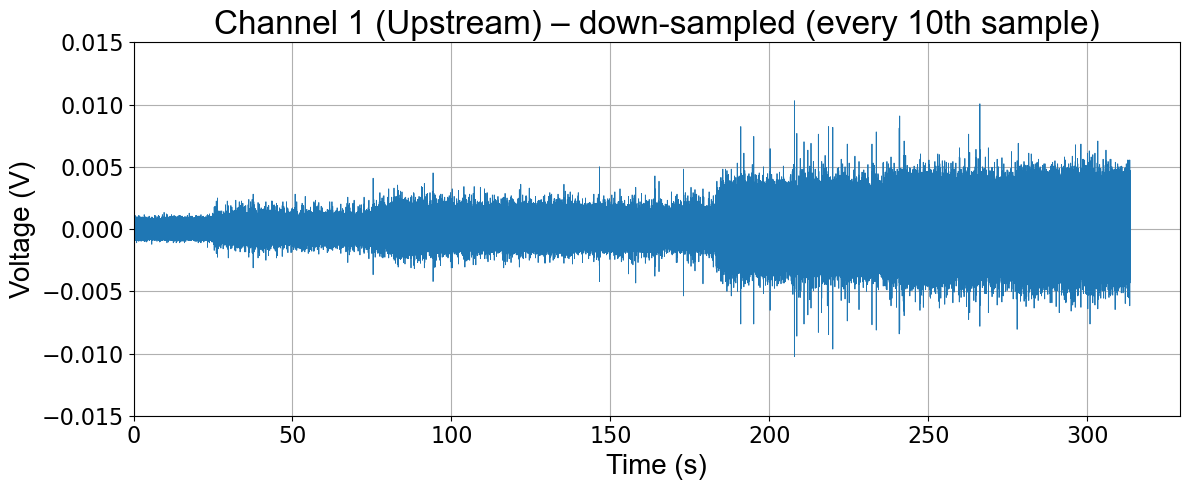

In [83]:
plt.figure(figsize=(12, 5))
plt.plot(ch1_ds[:, 0], ch1_ds[:, 1], linewidth=0.6)
plt.title(f"Channel 1 (Upstream) – down-sampled (every {ds_factor}th sample)",fontsize = 24, fontname ='Arial')
plt.xlabel("Time (s)", fontsize = 20, fontname ='Arial')
plt.ylabel("Voltage (V)", fontsize = 20, fontname ='Arial')
plt.grid(True)
plt.xlim(0,None)
plt.ylim(-0.01,0.01)
plt.yticks(np.arange(-0.015, 0.015 + 0.001, 0.005))  # ticks at -0.02, -0.01, 0, 0.01, 0.02
# make tick labels bigger
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()

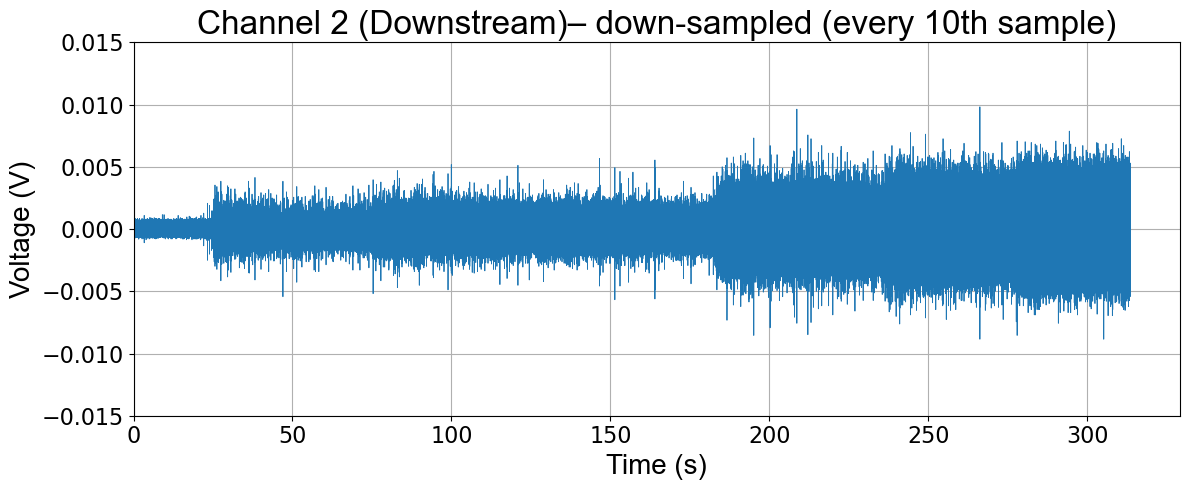

In [84]:
plt.figure(figsize=(12, 5))
plt.plot(ch2_ds[:, 0], ch2_ds[:, 1], linewidth=0.6)
plt.title(f"Channel 2 (Downstream)– down-sampled (every {ds_factor}th sample)", fontsize = 24, fontname ='Arial')
plt.xlabel("Time (s)", fontsize = 20, fontname ='Arial')
plt.ylabel("Voltage (V)", fontsize = 20, fontname ='Arial')
plt.xlim(0,None)
plt.ylim(-0.01,0.01)
plt.yticks(np.arange(-0.015, 0.015 + 0.001, 0.005))  # ticks at -0.02, -0.01, 0, 0.01, 0.02
# make tick labels bigger
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

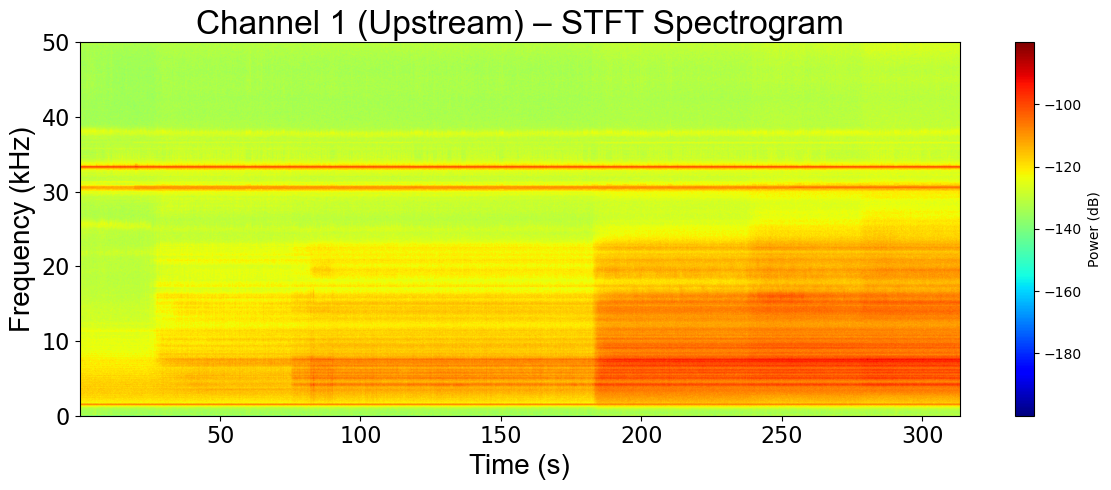

In [85]:
# pick a window length like before
nperseg = 1024

# limit the y-axis to this freq (Hz)
max_freq = 1000000   # 100 kHz, change if your data is lower/higher

# =========================================================
# STFT / Spectrogram for CHANNEL 1 (downsampled)
# =========================================================

# 1) effective sampling frequency AFTER downsampling
fs_ch1 = 1.0 / ch1_meta["sample_interval"]      # original fs
fs_ch1_ds = fs_ch1 / ds_factor                  # because we took every 1000th sample

# 2) get the voltage only (1D)
ch1_sig_ds = ch1_ds[:, 1]

# 3) compute spectrogram
f1, t1, Sxx1 = spectrogram(
    ch1_sig_ds,
    fs=fs_ch1_ds,
    nperseg=nperseg
)

# 4) convert to dB
Sxx1_db = 10 * np.log10(Sxx1 + 1e-20)  # avoid log(0)

# 5) mask high freqs
freq_mask_1 = f1 <= max_freq
f1_masked = f1[freq_mask_1]
Sxx1_db_masked = Sxx1_db[freq_mask_1, :]

# 6) plot
plt.figure(figsize=(12, 5))
plt.imshow(
    Sxx1_db_masked,
    extent=[t1[0], t1[-1], f1_masked[0] / 1e3, f1_masked[-1] / 1e3],
    origin="lower",
    aspect="auto",
    cmap="jet"
)
plt.colorbar(label="Power (dB)")
plt.title("Channel 1 (Upstream) – STFT Spectrogram", fontsize = 24, fontname ='Arial')
plt.xlabel("Time (s)", fontsize = 20, fontname ='Arial')
plt.ylabel("Frequency (kHz)", fontsize = 20, fontname ='Arial')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()


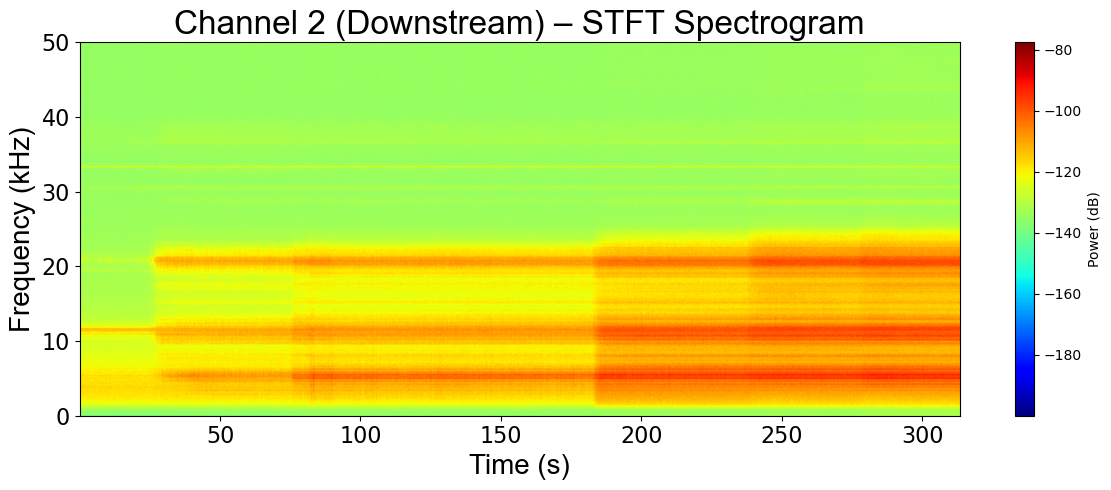

In [86]:
# =========================================================
# STFT / Spectrogram for CHANNEL 2 (downsampled)
# =========================================================

# 1) effective sampling frequency AFTER downsampling
fs_ch2 = 1.0 / ch2_meta["sample_interval"]
fs_ch2_ds = fs_ch2 / ds_factor

# 2) voltage only
ch2_sig_ds = ch2_ds[:, 1]

# 3) compute spectrogram
f2, t2, Sxx2 = spectrogram(
    ch2_sig_ds,
    fs=fs_ch2_ds,
    nperseg=nperseg
)

# 4) convert to dB
Sxx2_db = 10 * np.log10(Sxx2 + 1e-20)

# 5) mask high freqs
freq_mask_2 = f2 <= max_freq
f2_masked = f2[freq_mask_2]
Sxx2_db_masked = Sxx2_db[freq_mask_2, :]

# 6) plot
plt.figure(figsize=(12, 5))
plt.imshow(
    Sxx2_db_masked,
    extent=[t2[0], t2[-1], f2_masked[0] / 1e3, f2_masked[-1] / 1e3],
    origin="lower",
    aspect="auto",
    cmap="jet"
)
plt.colorbar(label="Power (dB)")
plt.title("Channel 2 (Downstream) – STFT Spectrogram", fontsize = 24, fontname ='Arial')
plt.xlabel("Time (s)", fontsize = 20, fontname ='Arial')
plt.ylabel("Frequency (kHz)", fontsize = 20, fontname ='Arial')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()